In [2]:
%pylab inline

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Objective function analysis
VIC parameters were calibrated with NSE, scaled KGEs and annual peak Q error, at each of 670 HCDN basins independently. SCE was used with 20,000 maximum trials. 

In [3]:
# Getting Data: 
# 1. Parameters traced during SCE [n_hru x n_par x n_iteration]
# 2. hydrologic signatures traced during SCE [n_hru x n_sig x n_iteration]
# 3. final calibrated parameters [n_hru x n_calpar]
# 4. Camel dataset [n_hru x n_attr]

data_path = './data'

main_obj_fun = ['nse','kge','kge_2alpha','kge_5alpha','sig1']
sup_obj_fun = ['kge_alpha'] #'kge_10alpha'

ds_vic_flow_all = xr.open_dataset('%s/results_hcdn_flow_vic_491.nc'%data_path)
ds_mhm_flow_all = xr.open_dataset('%s/results_hcdn_flow_mhm_491.nc'%data_path)

df_hcdn = pd.read_csv('%s/hcdn.calib.conus.491.list'%data_path, delim_whitespace=True,
                   header=None, names=['id', 'lat', 'lon'])

nbasin = len(df_hcdn['id'])
ndata = len(main_obj_fun)
sup_ndata = len(sup_obj_fun)

print(ds_vic_flow_all)
print(ds_mhm_flow_all)

<xarray.Dataset>
Dimensions:      (hcdn: 491, time: 6940)
Coordinates:
  * hcdn         (hcdn) int64 1022500 1031500 1047000 1052500 1055000 ...
  * time         (time) datetime64[ns] 1989-10-01 1989-10-02 1989-10-03 ...
Data variables:
    nse          (hcdn, time) float64 0.5326 1.111 1.355 1.285 1.077 0.8687 ...
    kge          (hcdn, time) float64 0.9231 1.497 1.748 1.69 1.492 1.282 ...
    kge_alpha    (hcdn, time) float64 0.9941 1.358 1.504 1.457 1.342 1.238 ...
    kge_2alpha   (hcdn, time) float64 0.8617 1.428 1.679 1.626 1.433 1.225 ...
    kge_5alpha   (hcdn, time) float64 0.9484 1.523 1.772 1.715 1.517 1.307 ...
    kge_10alpha  (hcdn, time) float64 0.9424 1.513 1.761 1.704 1.508 1.298 ...
    sig1         (hcdn, time) float64 1.487 1.71 1.764 1.692 1.592 1.509 ...
    obs          (hcdn, time) float64 0.6203 0.5537 0.7119 0.8076 0.7369 ...
<xarray.Dataset>
Dimensions:     (hcdn: 491, time: 6940)
Coordinates:
  * hcdn        (hcdn) int64 1022500 1031500 1047000 1052500 1055

In [4]:
#Functions

def nse(qsim, qobs):
    return 1-np.sum((qsim-qobs)**2)/np.sum((qobs-np.mean(qobs))**2)

    
def corr(qsim, qobs):
    return np.corrcoef(qsim, qobs)[0, 1]
    
    
def alpha(qsim, qobs):
    return math.sqrt(np.sum((qsim-np.mean(qsim))**2)/len(qsim))/math.sqrt(np.sum((qobs-np.mean(qobs))**2)/len(qobs))
    

def beta(qsim, qobs):
    return np.mean(qsim)/np.mean(qobs)


def kge(qsim, qobs):
    return 1-math.sqrt((1-corr(qsim, qobs))**2 + (alpha(qsim, qobs)-1)**2 + (beta(qsim, qobs)-1)**2)


def pbias(qsim, qobs):
    return np.sum((qsim-qobs))/np.sum(qobs)

In [5]:
# Calibration period
ds_vic_flow_cal = ds_vic_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))
ds_mhm_flow_cal = ds_mhm_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))

#Initialize dictionary
nse_cal = {}
alpha_cal = {}
beta_cal = {} 
corr_cal = {} 
kge_cal = {} 
pbiasFHV_cal = {}
pbiasQpeak_cal = {} 

prob_cal=np.arange(1,float(len(ds_vic_flow_cal['time'])+1))/(1+len(ds_vic_flow_cal['time'])) #probability
for d in range(len(prob_cal)):
    idx50=d
    if prob_cal[d] > 0.5: break
for d in range(len(prob_cal)):
    idx30=d
    if prob_cal[d] > 0.3: break
for d in range(len(prob_cal)):
    idx80=d
    if prob_cal[d] > 0.8: break

for model in ['vic','mhm']:
    nse_array = np.zeros((nbasin, ndata))
    alpha_array = np.zeros((nbasin, ndata))
    beta_array = np.zeros((nbasin, ndata))
    corr_array = np.zeros((nbasin, ndata))
    kge_array = np.zeros((nbasin, ndata))
    pbiasFHV_array = np.zeros((nbasin, ndata))
    pbiasQpeak_array = np.zeros((nbasin, ndata))     
    r=0
    for hid in df_hcdn['id']:
        for c, obj in enumerate(main_obj_fun): 
            if model == 'vic':
                sr_sim = ds_vic_flow_cal[obj].sel(hcdn=hid).to_pandas() 
            elif model =='mhm':
                sr_sim = ds_mhm_flow_cal[obj].sel(hcdn=hid).to_pandas()
                
            sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
            sr_sim_sort = sr_sim.sort_values()
            sr_sim_ann=sr_sim.resample('A-SEP').max()
            if c == 0:
                if model == 'vic':
                    sr_obs = ds_vic_flow_cal['obs'].sel(hcdn=hid).to_pandas()
                elif model =='mhm':
                    sr_obs = ds_mhm_flow_cal['obs'].sel(hcdn=hid).to_pandas()
                sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
                sr_obs_sort = sr_obs.sort_values()
                sr_obs_ann=sr_obs.resample('A-SEP').max()
            
            nse_array[r,c] = nse(sr_sim, sr_obs)
            alpha_array[r,c] = alpha(sr_sim, sr_obs)
            beta_array[r,c] = beta(sr_sim, sr_obs)
            corr_array[r,c] = corr(sr_sim, sr_obs)
            kge_array[r,c] = kge(sr_sim, sr_obs)
            pbiasQpeak_array[r,c] = pbias(sr_sim_ann, sr_obs_ann)
            pbiasFHV_array[r,c] = pbias(sr_sim_sort[idx80:], sr_obs_sort[idx80:])
               
        r += 1
        
    nse_cal[model] = nse_array
    alpha_cal[model] = alpha_array
    beta_cal[model] = beta_array
    corr_cal[model] = corr_array
    kge_cal[model] = kge_array
    pbiasQpeak_cal[model] = pbiasQpeak_array
    pbiasFHV_cal[model] = pbiasFHV_array

In [6]:
# Validation period
ds_vic_flow_val = ds_vic_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))
ds_mhm_flow_val = ds_mhm_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))

#Initialize dictionary
nse_val = {}
alpha_val = {}
beta_val = {} 
corr_val = {} 
kge_val = {} 
pbiasFHV_val = {}
pbiasQpeak_val = {} 

prob_val=np.arange(1,float(len(ds_vic_flow_val['time'])+1))/(1+len(ds_vic_flow_val['time'])) #probability
for d in range(len(prob_val)):
    idx50=d
    if prob_val[d] > 0.5: break
for d in range(len(prob_val)):
    idx30=d
    if prob_val[d] > 0.3: break
for d in range(len(prob_val)):
    idx80=d
    if prob_val[d] > 0.8: break

for model in ['vic','mhm']:
    nse_array = np.zeros((nbasin, ndata))
    alpha_array = np.zeros((nbasin, ndata))
    beta_array = np.zeros((nbasin, ndata))
    corr_array = np.zeros((nbasin, ndata))
    kge_array = np.zeros((nbasin, ndata))
    pbiasFHV_array = np.zeros((nbasin, ndata))
    pbiasQpeak_array = np.zeros((nbasin, ndata))     
    r=0
    for hid in df_hcdn['id']:
        for c, obj in enumerate(main_obj_fun): 
            if model == 'vic':
                sr_sim = ds_vic_flow_val[obj].sel(hcdn=hid).to_pandas() 
            elif model =='mhm':
                sr_sim = ds_mhm_flow_val[obj].sel(hcdn=hid).to_pandas()
                
            sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
            sr_sim_sort = sr_sim.sort_values()
            sr_sim_ann=sr_sim.resample('A-SEP').max()
            if c == 0:
                if model == 'vic':
                    sr_obs = ds_vic_flow_val['obs'].sel(hcdn=hid).to_pandas()
                elif model =='mhm':
                    sr_obs = ds_mhm_flow_val['obs'].sel(hcdn=hid).to_pandas()
                sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
                sr_obs_sort = sr_obs.sort_values()
                sr_obs_ann=sr_obs.resample('A-SEP').max()
            
            nse_array[r,c] = nse(sr_sim, sr_obs)
            alpha_array[r,c] = alpha(sr_sim, sr_obs)
            beta_array[r,c] = beta(sr_sim, sr_obs)
            corr_array[r,c] = corr(sr_sim, sr_obs)
            kge_array[r,c] = kge(sr_sim, sr_obs)
            pbiasQpeak_array[r,c] = pbias(sr_sim_ann, sr_obs_ann)
            pbiasFHV_array[r,c] = pbias(sr_sim_sort[idx80:], sr_obs_sort[idx80:])
               
        r += 1
        
    nse_val[model] = nse_array
    alpha_val[model] = alpha_array
    beta_val[model] = beta_array
    corr_val[model] = corr_array
    kge_val[model] = kge_array
    pbiasQpeak_val[model] = pbiasQpeak_array
    pbiasFHV_val[model] = pbiasFHV_array

In [10]:
# Annual flood Frequency analysis based on the entire time serise

yrs = pd.date_range('1989-10-01', '2008-09-30', freq='A-SEP')
prob_ann = np.arange(1,float(len(yrs)+1))/(1+float(len(yrs))) #probability
for d in range(len(prob_ann)):
    idx20=d
    if prob_ann[d] > 0.95: break
for d in range(len(prob_ann)):
    idx10=d
    if prob_ann[d] > 0.90: break
for d in range(len(prob_ann)):
    idx5=d
    if prob_ann[d] > 0.80: break

pbiasQ20 = {}
pbiasQ10 = {}
pbiasQ5 = {}
for model in ['mhm','vic']:        
    pbiasQ20_array = np.zeros((nbasin,ndata))
    pbiasQ10_array = np.zeros((nbasin,ndata))
    pbiasQ5_array = np.zeros((nbasin,ndata))
    r=0
    for hid in df_hcdn['id']:
        for c, obj in enumerate(main_obj_fun):
            if model == 'vic':
                sr_sim = ds_vic_flow_all[obj].sel(hcdn=hid).to_pandas()
            elif model == 'mhm':    
                sr_sim = ds_mhm_flow_all[obj].sel(hcdn=hid).to_pandas()
            sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
            sr_sim_ann = sr_sim.resample('A-SEP').max()
            sr_sim_ann_sort = sr_sim_ann.sort_values()
            if c == 0:
                if model == 'vic':
                    sr_obs = ds_vic_flow_all['obs'].sel(hcdn=hid).to_pandas()
                elif model == 'mhm':
                    sr_obs = ds_mhm_flow_all['obs'].sel(hcdn=hid).to_pandas()
                sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
                sr_obs_ann=sr_obs.resample('A-SEP').max()
                sr_obs_ann_sort = sr_obs_ann.sort_values()
            
            pbiasQ20_array[r,c] = pbias(sr_sim_ann_sort[idx20], sr_obs_ann_sort[idx20])
            pbiasQ10_array[r,c] = pbias(sr_sim_ann_sort[idx10], sr_obs_ann_sort[idx10])
            pbiasQ5_array[r,c] = pbias(sr_sim_ann_sort[idx5], sr_obs_ann_sort[idx5])
        r += 1

    pbiasQ20[model] = pbiasQ20_array
    pbiasQ10[model] = pbiasQ10_array
    pbiasQ5[model] = pbiasQ5_array

In [11]:
# Compute quartiles and median for metrics for each objective function and period
# Multi-level header
iterables = [main_obj_fun, ['cal', 'val']]
index = pd.MultiIndex.from_product(iterables)

#Initialize dictionary
nse_all = {}
alpha_all = {}
beta_all = {} 
corr_all = {} 
kge_all = {} 
pbiasFHV_all = {}
pbiasQpeak_all = {} 

for model in ['vic','mhm']:
    # Combine cal and val arrays
    nse_all_array = np.zeros((nbasin,ndata*2))
    kge_all_array = np.zeros((nbasin,ndata*2))
    alpha_all_array = np.zeros((nbasin,ndata*2))
    beta_all_array = np.zeros((nbasin,ndata*2))
    corr_all_array = np.zeros((nbasin,ndata*2))
    for idx, _ in enumerate(main_obj_fun):
        nse_all_array[:,idx*2] = nse_cal[model][:,idx]
        nse_all_array[:,idx*2+1] = nse_val[model][:,idx]
        kge_all_array[:,idx*2] = kge_cal[model][:,idx]
        kge_all_array[:,idx*2+1] = kge_val[model][:,idx]    
        alpha_all_array[:,idx*2] = alpha_cal[model][:,idx]
        alpha_all_array[:,idx*2+1] = alpha_val[model][:,idx]    
        beta_all_array[:,idx*2] = beta_cal[model][:,idx]
        beta_all_array[:,idx*2+1] = beta_val[model][:,idx]    
        corr_all_array[:,idx*2] = corr_cal[model][:,idx]
        corr_all_array[:,idx*2+1] = corr_val[model][:,idx]
        
    nse_all[model] = nse_all_array
    kge_all[model] = kge_all_array
    alpha_all[model] = alpha_all_array
    beta_all[model] = beta_all_array
    corr_all[model] = corr_all_array
    
# convert numpy arrays to DataFrames
df_nse_vic = pd.DataFrame(nse_all['vic'], index=df_hcdn['id'], columns=index)
df_kge_vic = pd.DataFrame(kge_all['vic'], index=df_hcdn['id'], columns=index)
df_alpha_vic = pd.DataFrame(alpha_all['vic'], index=df_hcdn['id'], columns=index)
df_beta_vic = pd.DataFrame(beta_all['vic'], index=df_hcdn['id'], columns=index)
df_corr_vic = pd.DataFrame(corr_all['vic'], index=df_hcdn['id'], columns=index)

# convert numpy arrays to DataFrames
df_nse_mhm = pd.DataFrame(nse_all['mhm'], index=df_hcdn['id'], columns=index)
df_kge_mhm = pd.DataFrame(kge_all['mhm'], index=df_hcdn['id'], columns=index)
df_alpha_mhm = pd.DataFrame(alpha_all['mhm'], index=df_hcdn['id'], columns=index)
df_beta_mhm = pd.DataFrame(beta_all['mhm'], index=df_hcdn['id'], columns=index)
df_corr_mhm = pd.DataFrame(corr_all['mhm'], index=df_hcdn['id'], columns=index)

# Print quartiles
pd.options.display.float_format = '{:,.2f}'.format
print('VIC')
print('NSE')
print(df_nse_vic.quantile([.25, .5, .75]))
print('\nKGE')
print(df_kge_vic.quantile([.25, .5, .75]))
print('\nalpha')
print(df_alpha_vic.quantile([.25, .5, .75]))
print('\nbeta')
print(df_beta_vic.quantile([.25, .5, .75]))
print('\ncorr')
print(df_corr_vic.quantile([.25, .5, .75]))
print('-------------------')
print('\nmHM')
print('NSE')
print(df_nse_mhm.quantile([.25, .5, .75]))
print('\nKGE')
print(df_kge_mhm.quantile([.25, .5, .75]))
print('\nalpha')
print(df_alpha_mhm.quantile([.25, .5, .75]))
print('\nbeta')
print(df_beta_mhm.quantile([.25, .5, .75]))
print('\ncorr')
print(df_corr_mhm.quantile([.25, .5, .75]))
print('-------------------')

VIC
NSE
      nse       kge      kge_2alpha      kge_5alpha       sig1      
      cal  val  cal  val        cal  val        cal  val   cal   val
0.25 0.49 0.46 0.42 0.41       0.32 0.33       0.26 0.28 -0.54 -0.14
0.50 0.59 0.55 0.52 0.52       0.46 0.48       0.41 0.43 -0.02  0.20
0.75 0.69 0.64 0.64 0.62       0.62 0.60       0.60 0.59  0.29  0.38

KGE
      nse       kge      kge_2alpha      kge_5alpha       sig1      
      cal  val  cal  val        cal  val        cal  val   cal   val
0.25 0.50 0.45 0.53 0.49       0.48 0.48       0.40 0.44 -0.29 -0.00
0.50 0.63 0.59 0.69 0.64       0.67 0.63       0.66 0.61  0.21  0.34
0.75 0.73 0.69 0.80 0.74       0.79 0.74       0.78 0.73  0.52  0.57

alpha
      nse       kge      kge_2alpha      kge_5alpha      sig1     
      cal  val  cal  val        cal  val        cal  val  cal  val
0.25 0.65 0.60 0.72 0.66       0.90 0.76       0.98 0.82 1.13 0.99
0.50 0.74 0.72 0.92 0.83       0.98 0.89       0.99 0.92 1.29 1.15
0.75 0.84 0.82 0.99 0.

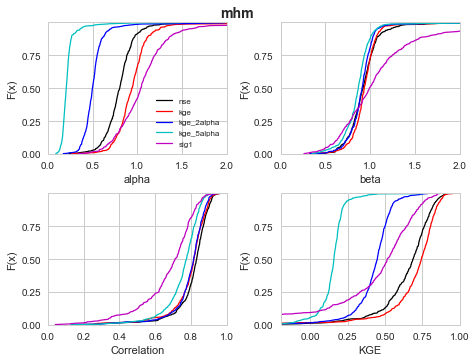

In [14]:
# 4 panel CDFs (alpha, beta, correlation and KGE)
model = 'mhm'

fig = plt.figure(figsize=(6.5, 5.0))
fig.suptitle('%s' % model, fontsize=14, fontweight='bold')
fig.subplots_adjust(left=0.095,right=0.975,bottom=0.095,top=0.935,wspace=0.3,hspace=0.3)
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

clr=['k','r','b','c','m','g']
lstyle=['-','-','-','-','-','-','-']

#panel a) alpha
for c in range(ndata):
    xdata = alpha_val[model][:,c]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax1.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=main_obj_fun[c],linewidth=1.25)
lgd = ax1.legend(loc="lower right", handlelength=2, prop={'size':8})
ax1.set_xlim(0.0, 2.0) #ratio
ax1.set_ylim(0, 1)
ax1.set_yticks(np.arange(0, 1, 0.25))
ax1.set_xlabel('alpha')
ax1.set_ylabel('F(x)')

#panel b) beta
for c in range(ndata):
    xdata = beta_val[model][:,c]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax2.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=main_obj_fun[c],linewidth=1.25)
ax2.set_xlim(0.0, 2.0) #ratio
ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1, 0.25))
ax2.set_xlabel('beta')
ax2.set_ylabel('F(x)')

#panel c) correlation
for c in range(ndata):
    xdata = corr_val[model][:,c]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax3.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=main_obj_fun[c],linewidth=1.25)
ax3.set_xlim(0.0, 1.0) # corr
ax3.set_ylim(0, 1)
ax3.set_yticks(np.arange(0, 1, 0.25))
ax3.set_xlabel('Correlation')
ax3.set_ylabel('F(x)')

#panel d) KGE
for c in range(ndata):
    xdata = kge_val[model][:,c]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax4.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=main_obj_fun[c],linewidth=1.25)
ax4.set_xlim(-0.2, 1.0)
ax4.set_ylim(0, 1)
ax4.set_yticks(np.arange(0, 1, 0.25))
ax4.set_xlabel('KGE')
ax4.set_ylabel('F(x)')
plt.savefig('../../Paper5_ffa/supple_figure/kge.cdf.%s.pdf'%(model),
            format='pdf', 
            dpi=300,
            bbox_extra_artists=(lgd,)) 
            #bbox_inches='tight')

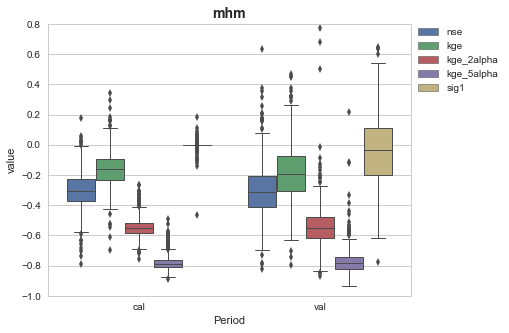

In [16]:
# Construct boxplots for metrics group-by periods
model = 'mhm'
df_pbiasQpeak_cal = pd.DataFrame(pbiasQpeak_cal[model], index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQpeak_val = pd.DataFrame(pbiasQpeak_val[model], index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQpeak_cal['Period'] = ['cal' for _ in df_hcdn['id']]
df_pbiasQpeak_val['Period'] = ['val' for _ in df_hcdn['id']]
df_pbiasQpeak = pd.concat([df_pbiasQpeak_cal, df_pbiasQpeak_val], axis=0)

dd_pbiasQpeak=pd.melt(df_pbiasQpeak, id_vars=['Period'], value_vars=main_obj_fun, var_name='OF')

plt.figure(figsize=(6.5,5))
sns.set_style("whitegrid")
ax11 = sns.boxplot(x='Period', y='value', data=dd_pbiasQpeak, hue='OF', linewidth=1.0)
handles, labels = ax11.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax11.set_ylim([-1.0,0.8])
ax11.set_title('%s' % model, fontsize=14, fontweight='bold')
plt.savefig('../../Paper5_ffa/supple_figure/pbiasQpeak.boxplot.%s.pdf'%(model),
            format='pdf', 
            dpi=300,
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

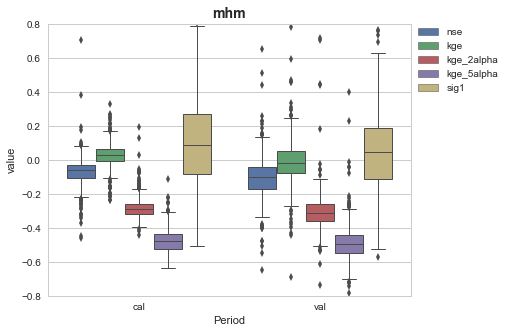

In [20]:
# Construct boxplots for metrics group-by periods
model = 'mhm'
df_pbiasFHV_cal = pd.DataFrame(pbiasFHV_cal[model], index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasFHV_val = pd.DataFrame(pbiasFHV_val[model], index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasFHV_cal['Period'] = ['cal' for _ in df_hcdn['id']]
df_pbiasFHV_val['Period'] = ['val' for _ in df_hcdn['id']]
df_pbiasFHV = pd.concat([df_pbiasFHV_cal, df_pbiasFHV_val], axis=0)

dd=pd.melt(df_pbiasFHV, id_vars=['Period'], value_vars=main_obj_fun, var_name='OF')

plt.figure(figsize=(6.5,5))
sns.set_style("whitegrid")
ax21 = sns.boxplot(x='Period', y='value', data=dd, hue='OF', linewidth=1.0)
handles, labels = ax21.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax21.set_ylim([-0.8,0.8])
ax21.set_title('%s' % model, fontsize=14, fontweight='bold')
plt.savefig('../../Paper5_ffa/supple_figure/pbiasFHV.boxplot.%s.pdf' % (model),
            format='pdf', 
            dpi=300, 
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

1. Plot
2. Explore relationship between Calibrated VIC parameter and Attributes

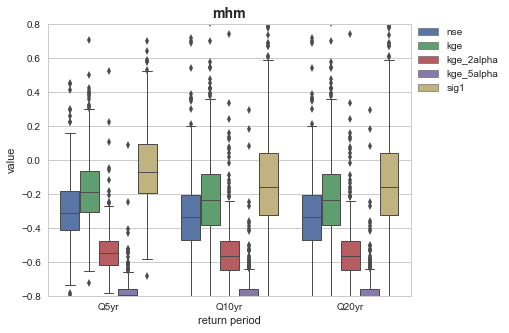

In [19]:
# Construct boxplots for metrics group-by periods
model = 'mhm'
df_pbiasQ20 = pd.DataFrame(pbiasQ20[model], index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQ10 = pd.DataFrame(pbiasQ10[model], index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQ5 = pd.DataFrame(pbiasQ5[model], index=df_hcdn['id'], columns=main_obj_fun)
df_pbiasQ20['return period'] = ['Q20yr' for _ in df_hcdn['id']]
df_pbiasQ10['return period'] = ['Q10yr' for _ in df_hcdn['id']]
df_pbiasQ5['return period'] = ['Q5yr' for _ in df_hcdn['id']]

df_pbiasQ = pd.concat([df_pbiasQ5, df_pbiasQ10, df_pbiasQ20], axis=0)

dd_Q = pd.melt(df_pbiasQ, id_vars=['return period'], value_vars=main_obj_fun, var_name='OF')

plt.figure(figsize=(6.5,5))
sns.set_style("whitegrid")
ax31 = sns.boxplot(x='return period', y='value', data=dd_Q, hue='OF', linewidth=1.0)
handles, labels = ax31.get_legend_handles_labels()
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax31.set_ylim([-0.8,0.8])
ax31.set_title('%s' % model, fontsize=14, fontweight='bold')
plt.savefig('../../Paper5_ffa/supple_figure/pbiasQ.boxplot.%s.pdf' % (model),
            format='pdf', 
            dpi=300, 
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

In [17]:
# VIC Validation period
ds_vic_flow_val = ds_vic_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))

#Initialize arrays
nse_val_vic_array = np.zeros((nbasin, ndata))
alpha_val_vic_array = np.zeros((nbasin, ndata))
beta_val_vic_array = np.zeros((nbasin, ndata))
corr_val_vic_array = np.zeros((nbasin, ndata))
kge_val_vic_array = np.zeros((nbasin, ndata))
pbiasFHV_val_vic_array = np.zeros((nbasin, ndata))
pbiasQpeak_val_vic_array = np.zeros((nbasin, ndata))

prob_val=np.arange(1,float(len(ds_vic_flow_val['time'])+1))/(1+len(ds_vic_flow_val['time'])) #probability
for d in range(len(prob_val)):
    idx50=d
    if prob_val[d] > 0.5: break
for d in range(len(prob_val)):
    idx30=d
    if prob_val[d] > 0.3: break
for d in range(len(prob_val)):
    idx80=d
    if prob_val[d] > 0.8: break
    
r=0
for hid in df_hcdn['id']:
    for c, obj in enumerate(main_obj_fun):
        sr_sim = ds_vic_flow_val[obj].sel(hcdn=hid).to_pandas()
        sr_sim.where(sr_sim>0.0, 1.0e-7, inplace=True)
        sr_sim_sort = sr_sim.sort_values()
        sr_sim_ann=sr_sim.resample('A-SEP').max()
        if c == 0:
            sr_obs = ds_vic_flow_val['obs'].sel(hcdn=hid).to_pandas()
            sr_obs.where(sr_obs>0.0, 1.0e-7, inplace=True)
            sr_obs_sort = sr_obs.sort_values()
            sr_obs_ann=sr_obs.resample('A-SEP').max()
            
        nse_val_vic_array[r,c] = nse(sr_sim, sr_obs)
        alpha_val_vic_array[r,c] = alpha(sr_sim, sr_obs)
        beta_val_vic_array[r,c] = beta(sr_sim, sr_obs)
        corr_val_vic_array[r,c] = corr(sr_sim, sr_obs)
        kge_val_vic_array[r,c] = kge(sr_sim, sr_obs)
        pbiasQpeak_val_vic_array[r,c] = pbias(sr_sim_ann, sr_obs_ann)
        pbiasFHV_val_array[r,c] = pbias(sr_sim_sort[idx80:], sr_obs_sort[idx80:])
               
    r += 1